In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import struct

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

fraud_data = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_data = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

print(f"Fraud Data Shape: {fraud_data.shape}")
fraud_data.head()

Fraud Data Shape: (151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
# Check for missing values in both datasets
print("--- Missing Values in Fraud Data ---")
print(fraud_data.isnull().sum())

print("\n--- Missing Values in IP Data ---")
print(ip_data.isnull().sum())

--- Missing Values in Fraud Data ---
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
time_diff         0
hour_of_day       0
day_of_week       0
dtype: int64

--- Missing Values in IP Data ---
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [ ]:
# Helper function for IP conversion
def ip_to_int(ip):
    try:
        return struct.unpack("!I", socket.inet_aton(ip))[0]
    except:
        return 0


fraud_data['ip_address'] = fraud_data['ip_address'].apply(lambda x: int(x) if isinstance(x, float) else ip_to_int(x))

# Create IntervalIndex for high-speed range lookup
intervals = pd.IntervalIndex.from_arrays(
    ip_data['lower_bound_ip_address'], 
    ip_data['upper_bound_ip_address'], 
    closed='both'
)

# Map IPs to Country
ip_mapping = ip_data.set_index(intervals)['country']

def map_ip(ip):
    try:
        return ip_mapping.iloc[ip_mapping.index.get_loc(ip)]
    except:
        return "Unknown"

fraud_data['country'] = fraud_data['ip_address'].apply(map_ip)

C:\Users\a_kas\AppData\Local\Temp\ipykernel_30360\95452028.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=fraud_data, palette='viridis')


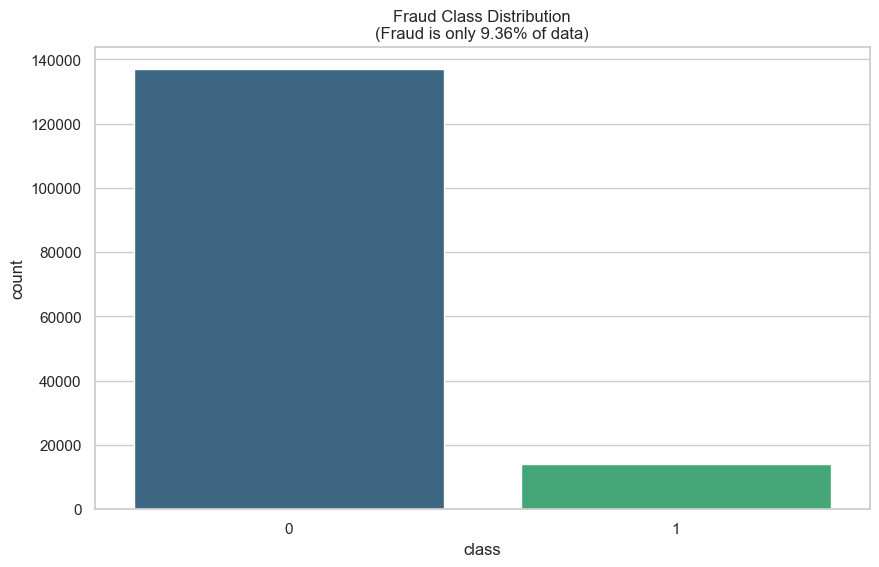

In [ ]:
# Count the occurrences
class_counts = fraud_data['class'].value_counts()
fraud_pct = (class_counts[1] / len(fraud_data)) * 100


sns.countplot(x='class', data=fraud_data, palette='viridis')
plt.title(f'Fraud Class Distribution\n(Fraud is only {fraud_pct:.2f}% of data)')
plt.show()

C:\Users\a_kas\AppData\Local\Temp\ipykernel_30360\2272077738.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fraud_rate', y='country', data=top_fraud_countries, palette='Reds_r')


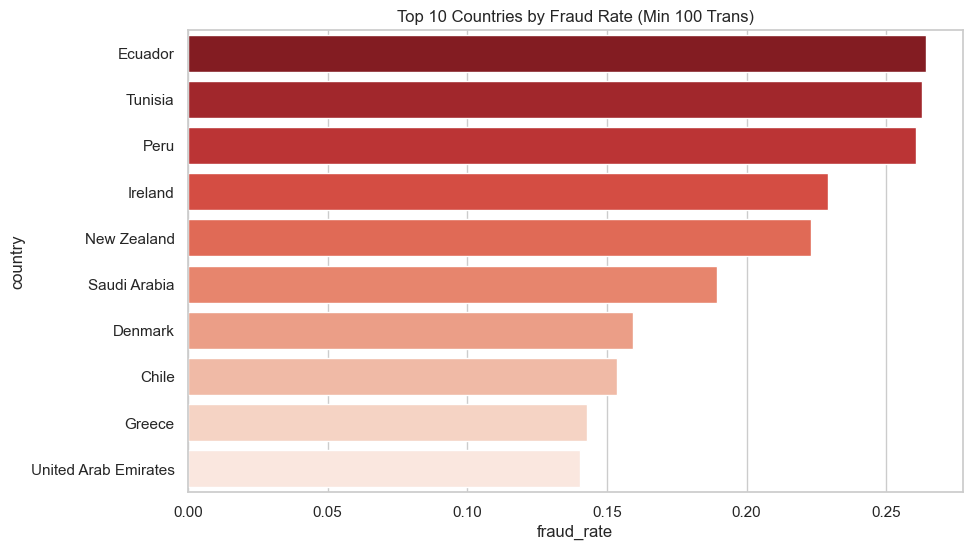

In [ ]:
# Calculate fraud rate per country
country_fraud = fraud_data.groupby('country')['class'].agg(['count', 'mean']).reset_index()
country_fraud.columns = ['country', 'total_transactions', 'fraud_rate']

# Filter for countries with significant traffic 
top_fraud_countries = country_fraud[country_fraud['total_transactions'] > 100].sort_values(by='fraud_rate', ascending=False).head(10)

sns.barplot(x='fraud_rate', y='country', data=top_fraud_countries, palette='Reds_r')
plt.title('Top 10 Countries by Fraud Rate (Min 100 Trans)')
plt.show()

Average Values by Class:
       purchase_value        age
class                           
0           36.929418  33.122356
1           36.993004  33.318281


C:\Users\a_kas\AppData\Local\Temp\ipykernel_30360\2113499297.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='purchase_value', data=fraud_data, palette='Set2')


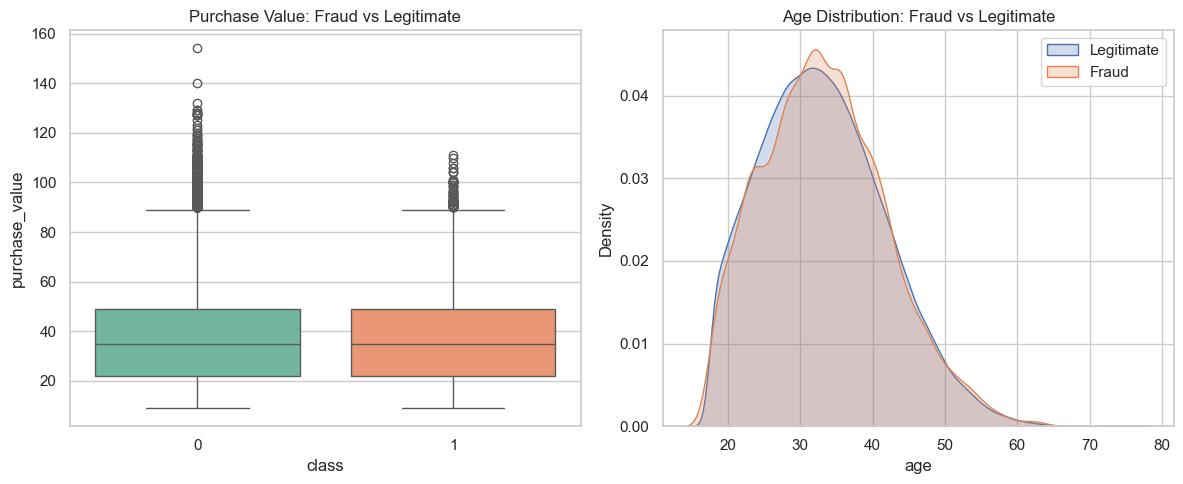

In [ ]:
#  Statistical Summary 
# Calculate the average purchase value and age for fraud vs. legitimate
stats = fraud_data.groupby('class')[['purchase_value', 'age']].mean()
print("Average Values by Class:")
print(stats)

# Visualization: Purchase Value 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='purchase_value', data=fraud_data, palette='Set2')
plt.title('Purchase Value: Fraud vs Legitimate')

# Visualization: Age 
plt.subplot(1, 2, 2)
sns.kdeplot(data=fraud_data[fraud_data['class']==0], x='age', label='Legitimate', fill=True)
sns.kdeplot(data=fraud_data[fraud_data['class']==1], x='age', label='Fraud', fill=True)
plt.title('Age Distribution: Fraud vs Legitimate')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\a_kas\AppData\Local\Temp\ipykernel_30360\2196704819.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_bucket', y='class', data=fraud_data, palette='coolwarm')


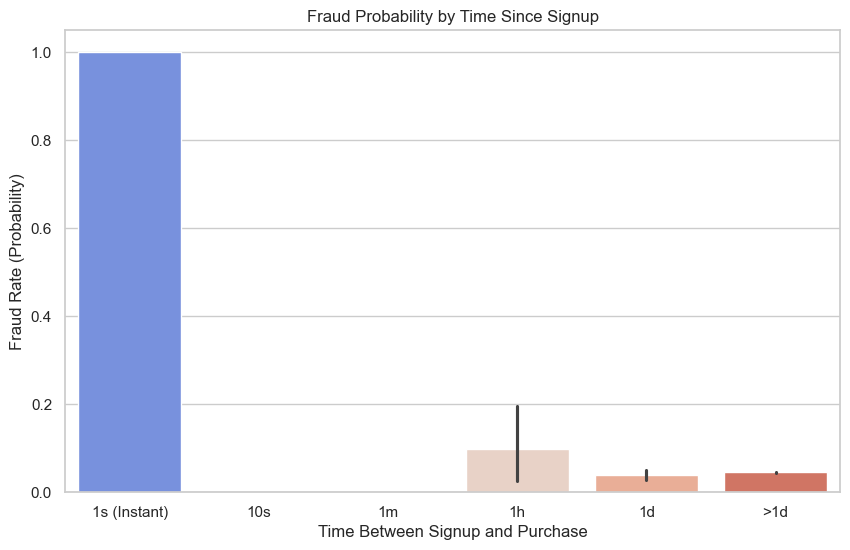

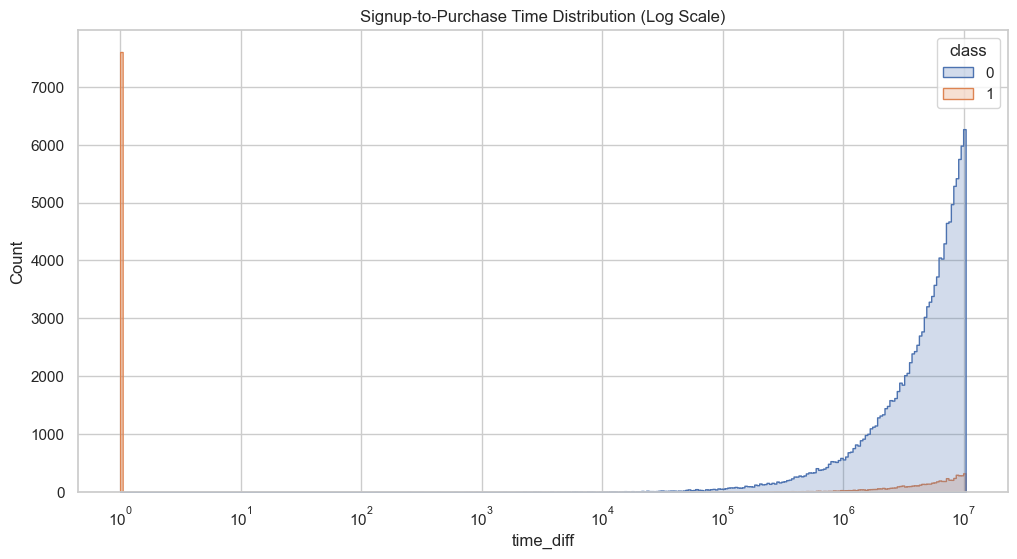

The fraud rate for 'Instant' (1s) purchases is: 100.00%


In [ ]:
# DENTIFY THE SPIKE: Categorize time_diff into meaningful buckets

fraud_data['time_bucket'] = pd.cut(fraud_data['time_diff'], 
                                   bins=[-1, 1, 10, 60, 3600, 86400, np.inf], 
                                   labels=['1s (Instant)', '10s', '1m', '1h', '1d', '>1d'])

# VISUALIZE THE SPIKE: Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='time_bucket', y='class', data=fraud_data, palette='coolwarm')
plt.title('Fraud Probability by Time Since Signup')
plt.ylabel('Fraud Rate (Probability)')
plt.xlabel('Time Between Signup and Purchase')
plt.show()

# Global Distribution (Log Scale)
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud_data, x='time_diff', hue='class', element='step', common_norm=False, log_scale=True)
plt.title('Signup-to-Purchase Time Distribution (Log Scale)')
plt.show()

fraud_data.to_csv('../data/processed/enriched_fraud_data.csv', index=False)

instant_fraud = fraud_data[fraud_data['time_diff'] <= 1]['class'].mean()
print(f"The fraud rate for 'Instant' (1s) purchases is: {instant_fraud:.2%}")

In [11]:
unknown_count = (fraud_data['country'] == 'Unknown').sum()
known_count = (fraud_data['country'] != 'Unknown').sum()
print(f"Mapped to Country: {known_count}")
print(f"Mapped to Unknown: {unknown_count}")

Mapped to Country: 129146
Mapped to Unknown: 21966
